In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
microsoft_5y = pd.read_csv("C:\\Users\\Jitendra Sharma\\Downloads\\MSFT.csv", index_col='Date', parse_dates=["Date"])
#test_set = pd.read_csv("C:\\Users\\Jitendra Sharma\\Downloads\\MSFT (3).csv")

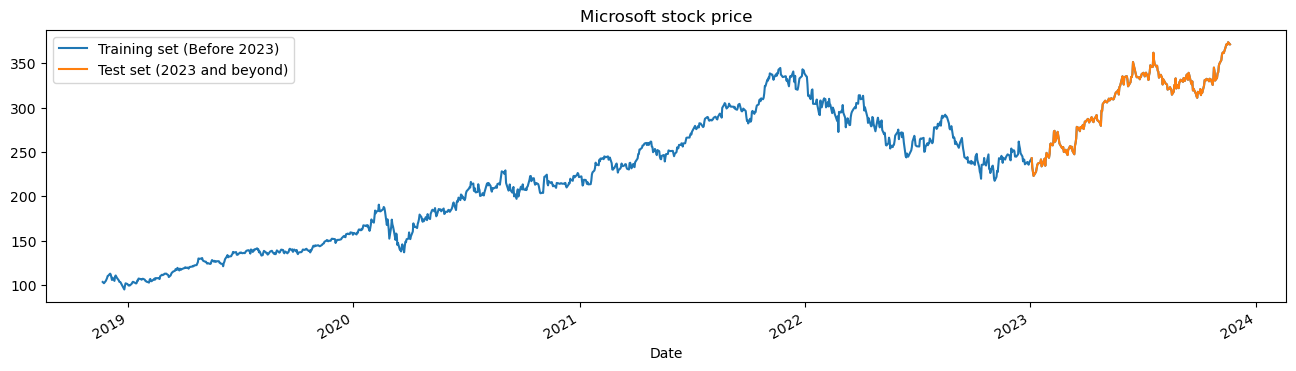

In [4]:
# Plot the training set
microsoft_5y["Open"][:'2023'].plot(figsize=(16, 4), legend=True)
# Plot the test set
microsoft_5y["Open"]['2023':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2023)', 'Test set (2023 and beyond)'])
plt.title('Microsoft stock price')
plt.show()

In [5]:
training_set = microsoft_5y[:'2023'].iloc[:, 1:2].values
test_set = microsoft_5y['2023':].iloc[:,1:2].values

In [6]:
# Feature Scaling with normalization as we use that with RNN

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
x_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
# Converting x_train and y_train into numpy array

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train.shape
# Let's reshape , as RNN takes in 3D format

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

x_train.shape

(1197, 60, 1)

In [9]:
# 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
model_gru = Sequential()

In [10]:
model_gru.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(tf.keras.layers.Dropout(0.3))
# Second GRU layer
model_gru.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(tf.keras.layers.Dropout(0.2))
# Third GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(tf.keras.layers.Dropout(0.1))
# Fourth GRU layer
model_gru.add(GRU(units=30, activation='tanh'))
model_gru.add(tf.keras.layers.Dropout(0.2))
# The output layer
model_gru.add(tf.keras.layers.Dense(units=1))

# Compiling the RNN
model_gru.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
gru_model = model_gru.fit(x_train,y_train,epochs=50,batch_size=120, validation_split=0.2)

Epoch 1/50
8/8 [==============================] - 10s 339ms/step - loss: 0.1061 - val_loss: 0.0168
Epoch 2/50
8/8 [==============================] - 1s 150ms/step - loss: 0.0259 - val_loss: 0.0571
Epoch 3/50
8/8 [==============================] - 1s 144ms/step - loss: 0.0188 - val_loss: 0.0076
Epoch 4/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0110 - val_loss: 0.0043
Epoch 5/50
8/8 [==============================] - 1s 188ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 6/50
8/8 [==============================] - 2s 217ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 7/50
8/8 [==============================] - 2s 217ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 8/50
8/8 [==============================] - 2s 208ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 9/50
8/8 [==============================] - 2s 221ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 10/50
8/8 [==============================] - 2s 235ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 11/50
8/8 [=

In [12]:
# Getting predicted stock prices of month Nov 2022
# Concatination
dataset_total = pd.concat((microsoft_5y['Open'][:'2023'], microsoft_5y['Open']['2023':]), axis=0)

# Stock prices of previous 60 days for each day of Nov 2022
inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values


# Converting this dataframe into numpy array.
inputs = inputs.reshape(-1,1)

# Feature Scaling
inputs = sc.transform(inputs)

# Creating a test set.
x_test = []
for i in range(60, len(inputs)):  # 80 for 20 days in novermber.
    x_test.append(inputs[i-60:i, 0])

# Convert in numpy array
x_test = np.array(x_test)

# Convert into 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Getting predicted stock prices
predicted_stock_price_gru = model_gru.predict(x_test)
predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)
predicted_stock_price_gru.shape

7/7 [==============================] - 2s 19ms/step


(223, 1)

In [13]:
x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predicted_stock_price_gru = model_gru.predict(x_test)
predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)

7/7 [==============================] - 0s 21ms/step


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# actual values

# predicted values

# calculate MSE
mse = mean_squared_error(test_set, predicted_stock_price_gru)

# calculate RMSE
rmse = sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 434.3368503165543
RMSE: 20.840749754184813


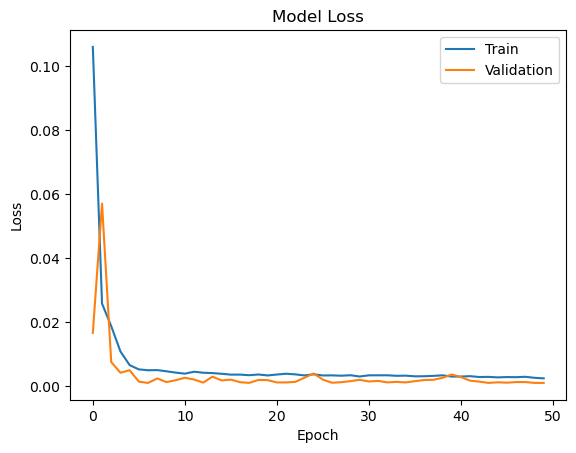

In [16]:
import matplotlib.pyplot as plt

# assuming history is a dictionary containing the loss and validation loss values
plt.plot(gru_model.history['loss'])
plt.plot(gru_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


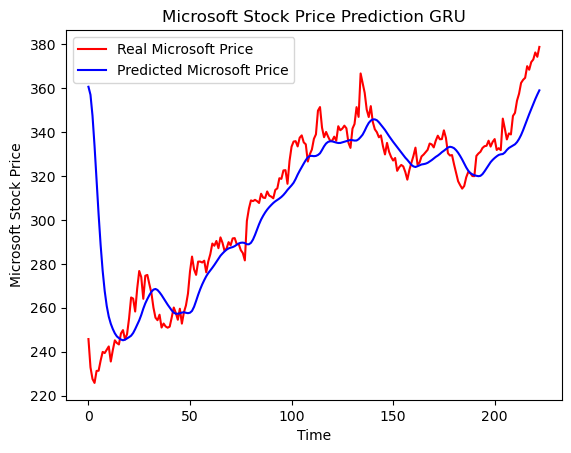

In [17]:
plt.plot(test_set, color = "red", label = "Real Microsoft Price")
plt.plot(predicted_stock_price_gru, color = "blue", label = "Predicted Microsoft Price")

plt.title("Microsoft Stock Price Prediction GRU")
plt.xlabel("Time")
plt.ylabel("Microsoft Stock Price")
plt.legend()
plt.show()